# Import necessary libraries

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import norm

# 1. Set time and import relevant data

In [266]:
years = 15 
end_time = datetime.today()
start_time = end_time - timedelta(days = years*365)

In [267]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [268]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker,
                       start = start_time,
                       end = end_time)
    adj_close_df[ticker] = data['Adj Close']
adj_close_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2008-12-01,61.450459,49.282436,75.650002,23.557211,30.400911
2008-12-02,63.815361,49.581329,76.949997,24.344492,31.599165
2008-12-03,65.349648,49.347416,76.180000,25.035555,32.413071
2008-12-04,63.837845,49.561848,75.500000,24.326994,31.448444
2008-12-05,65.806099,49.197952,74.519997,25.315472,32.563793
...,...,...,...,...,...
2023-11-21,453.269989,70.839996,185.350006,388.470001,224.179993
2023-11-22,455.019989,70.900002,184.559998,390.059998,225.139999
2023-11-24,455.299988,70.559998,185.520004,389.510010,225.380005


# 2. Computing Returns and Variability

## Compute the Daily Log Returns

In [269]:
# Log returns
log_returns_df = np.log(adj_close_df/adj_close_df.shift(1))
log_returns_df.dropna(inplace=True)
log_returns_df

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2008-12-02,0.037763,0.006047,0.017038,0.032874,0.038658
2008-12-03,0.023758,-0.004729,-0.010057,0.027991,0.025431
2008-12-04,-0.023406,0.004336,-0.008966,-0.028710,-0.030212
2008-12-05,0.030366,-0.007369,-0.013065,0.039829,0.034852
2008-12-08,0.034319,-0.004369,0.022294,0.038636,0.037475
...,...,...,...,...,...
2023-11-21,-0.002182,0.001413,0.010740,-0.005826,-0.002717
2023-11-22,0.003853,0.000847,-0.004271,0.004085,0.004273
2023-11-24,0.000615,-0.004807,0.005188,-0.001411,0.001065


In [270]:
# # Cummulative log returns
# cum_log_returns_df = log_returns_df.cumsum()
# cum_log_returns_df

## Function to compute the Portfolio Expected Returns

Here, we should compute the expected returns in a more realistic way. However, how to compute the expected returns is out of the scope of this tutorial, so we assume that they are the average of all the past years available.

In [271]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights.T)

In [272]:
# # Another (less efficient) way to do it would be:
# def expected_return(weights, log_returns):
#     return np.sum(log_returns @ weights.T)/len(log_returns)

## Function to compute the Portfolio Expected Returns

In [273]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [274]:
# # Another way to do it would be:
# def standard_deviation(weights, log_returns):
#     return (log_returns @ weights.T).std()

## Create Covariance Matrix for the securities portfolio

In [275]:
 cov_log_returns_df = log_returns_df.cov()

In [276]:
cov_log_returns_df

,SPY,BND,GLD,QQQ,VTI
SPY,1.329455e-04,-9.981611e-07,0.000006,1.425370e-04,1.357175e-04
BND,-9.981611e-07,9.330141e-06,0.000009,-2.088510e-07,-8.946833e-07
GLD,5.507243e-06,8.832321e-06,0.000102,5.807656e-06,6.031180e-06
QQQ,1.425370e-04,-2.088510e-07,0.000006,1.777968e-04,1.458861e-04
VTI,1.357175e-04,-8.946833e-07,0.000006,1.458861e-04,1.397080e-04


## Create a weighted portfolio and find total portfolio expected return and standard deviation

In [277]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [278]:
portfolio_expected_return = expected_return(weights, log_returns_df)
portfolio_std_dev = standard_deviation(weights, cov_log_returns_df)

print(round(portfolio_expected_return,4))
print(round(portfolio_standard_deviation, 4))

0.0004
0.0342


# 3. Monte Carlo Simulation

## Create a function that gives a random Z-score based on normal distribution

In [279]:
def random_z_score():
    return np.random.normal(0,1)

## Create a function to calculate scenarioGainLoss

In [280]:
def scenario_gain_loss(portfolio_value, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

## Run 10,000 simulations for the return of 20 days

In [281]:
days = 20
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    simulation_result = scenario_gain_loss(portfolio_value, z_score, days)
    scenarioReturn.append(simulation_result)

np.array(scenarioReturn[:10])

array([-28658.10029641,  62077.80344337,   6936.30269163, -52354.07600883,
       -22826.75898666,  16569.27654237, -12246.22174072,  40595.67515526,
       -96869.43046414,  21415.12852054])

# 4. Value at Risk

In [282]:
confidence_interval = 0.95

VaR = np.percentile(scenarioReturn, 100*(1-confidence_interval))
VaR

-47816.64124522986

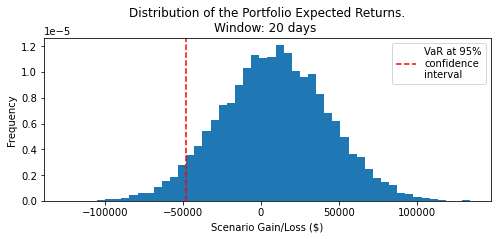

In [283]:
plt.figure(figsize=(8, 3))

plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of the Portfolio Expected Returns.\nWindow: {days} days ')
plt.axvline(VaR, color='r', linestyle='dashed', 
            label=f'VaR at {confidence_interval:.0%}\nconfidence\ninterval')
plt.legend()
plt.show()

# 5: Acknowledgement

This tutorial has been conducted following the video 'Value at Risk (VaR) In Python: Monte Carlo Method', by Ryan O'Connell. <br>
Video available at: <br>
https://www.youtube.com/watch?v=X8aNFXJEENs&list=PLPe-_ytPHqyg4ap7hysD4pOBJMz0mnLly&index=5&ab_channel=RyanO%27Connell%2CCFA%2CFRM